## Subthreshold simmulations

### Model 1a: 1 Src, 1 Int, 1 Tgt 
#### Variations of $G_{GABA \rightarrow Tgt}$ and $G_{AMPA \rightarrow Tgt}$

In the "net_conn.yaml" file, this is "Net_0"

In [1]:
# Import modules
from __future__ import division
from netSimObj import *
from analysis_functions_IW import *
from ipywidgets import FloatProgress
from IPython.display import display
from scipy import io as scio
prefs.codegen.target = 'cython' 
# use 'cython' instead of 'weave' since there were some problems with 'weave' that impacted speed 
# which i couldn't figure out why 

Total time elapsed = 1.263 s


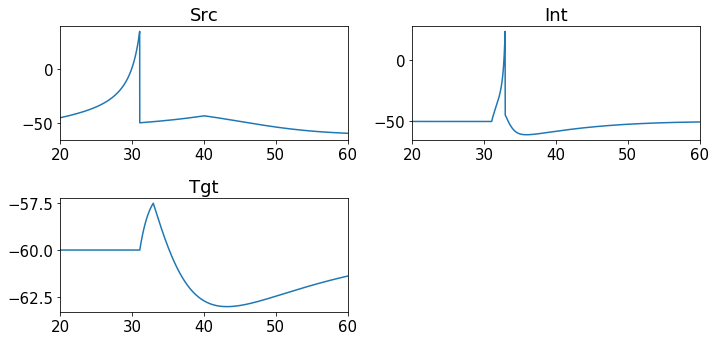

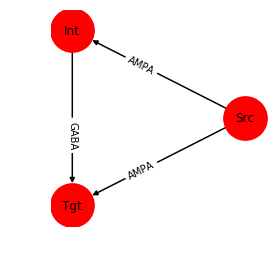

{'auc_epsp': 5.5502593140661656,
 'dt_epsp': 4.0999999999999979,
 'peak_epsp': 2.5023624951475867}

In [2]:
# Test running 1 simulation (Read this first to get an idea of setting up simulation and running with 'netSimObj')

# global and constant variables 
# difference is each is stored in a different field 
# 'netSimObj.glob' is for general simulation variables 
# 'netSimObj.const' is for constant kinetic parameters
globalVars = {'dt': 0.01*ms, 'tstop': 100*ms}
constVars = {'E_AMPA' : 0*mV, 'E_GABA' : -80*mV, 
             'tau_AMPA' : 2*ms, 'tau_GABA' : 10*ms}

# default values for synaptic conductance 
# this is stored in 'netSimObj.syn[default]'
# basically this is the default values for any conductance with the same type
# when running simulation in 'netSimObj', S_AMPA, S_GABA & S_elec were created 
#     taking some fields out wouldn't matter
#     but if there's error just set everything to 0
synapseVars = {'g_elec' : 0*nS, 'g_AMPA': 4*nS, 'g_GABA' : 8*nS} 

# this is to change default values of specific connections=
# this is stored in 'netSimObj.syn[custom]'
# each element's key is the connection (<presyn_name>, <syn_type>, <postsyn_name>)
# <*_name> have to match exactly with the ones found in net_conn 
#     (this does not apply when running simulation of network 
#      because network activity simulations need a slightly different code framework)
# <syn_type> can only be 'AMPA', 'GABA' or 'ELEC'
changeSynCond = { ('Src','AMPA','Int') : 10*nS }  

# setting DC inputs 
# 'i0': DC amplitude; 'ti': arrival time; 'tf': end time of DC input 
# note: i0 = 200 vs 300 pA doesn't matter for td_inp = 20 or 30 ms 
# using 300 pA with either td_inp just makes Src spikes a tad faster
# to avoid using too large tstop 
# using either td_inp doesn't matter since Src only gives out 1 spike either way 
ti_inp = 10*ms; td_inp = 30*ms
dcstimVars = {'Src': {'i0': 200*pA, 'ti': ti_inp, 'tf': ti_inp+td_inp},
              'Int': {'i0': 50*pA, 'ti': 0*ms, 'tf': globalVars['tstop']}    
             }

# initialize 'netSimObj' object 
# (<Izhikevich_param_file_location>, <Network_connectivity_file_location>, <Network_ID>)
nsO = netSimObj('../prm_files/prm.yaml', '../prm_files/net_conn.yaml', 'Net_0')
nsO.setGlobalVars(globalVars, constVars)
nsO.setSynapseVars(synapseVars,changeSynCond)
nsO.setDCStimVars(dcstimVars)

# run simulation 
# True = report time elapsed, False = don't print it out 
nsO.runSim(True) 

# plot example 
%matplotlib inline
figure(figsize = (10, 5))
rcParams["font.size"] = 15
# [] just means plot Vm in [ceil(N/2)]-by-2 subplots
# otherwise indicate actual subplot matrix 
nsO.plotSimulatedData([],lim_x=(20,60))

# plot network configuration
figure(figsize = (3,3))
rcParams["font.size"] = 15
nsO.drawNetwork()

# an estimate of the analyzed PSP
# however, these were not used for actual analysis
# actual analysis was done in MATLAB 
vm = nsO.returnData('Tgt')
tv  = nsO.data['t']
calc_IW(tv,vm)

In [ ]:
# Simulations with vairations of AMPA and GABA to Tgt
prefs.codegen.target = 'cython'
PRM_FILE = '../prm_files/prm.yaml'
NET_FILE = '../prm_files/net_conn.yaml'
NET_ID = 'Net_0'

globalVars = {'dt': 0.01*ms, 'tstop': 150*ms}
constVars = {'E_AMPA' : 0*mV, 'E_GABA' : -80*mV, 
             'tau_AMPA' : 2*ms, 'tau_GABA' : 10*ms}
changeSynCond = { ('Src','AMPA','Int') : 10*nS } 


ti_inp = 10*ms; td_inp = 30*ms
dcstimVars = {'Src': {'i0': 200*pA, 'ti': ti_inp, 'tf': ti_inp+td_inp}, \
              'Int': {'i0': 50*pA, 'ti': 0*ms, 'tf': globalVars['tstop']}    
             }
gvar_vec = np.arange(1,11,1)
num_dat = len(gvar_vec)**2
data2save = {'vars' : ('g_AMPA','g_GABA'), 
             'cell_names' : tuple(nsO.cell_names), 
             'cell_types' : tuple(nsO.cell_types),
             'g_AMPA' : gvar_vec, 
             'g_GABA' : gvar_vec, 
             'num_dat' : num_dat,             
            }

fprogress = FloatProgress(min=0, max=num_dat) # instantiate the bar
display(fprogress) # display the bar

startT = time.time() 
cnt_dat = 0

for g_AMPA_var in gvar_vec: 
    for g_GABA_var in gvar_vec: 
        synapseVars = {'g_elec' : 0*nS,\
                       'g_AMPA' : g_AMPA_var*nS, \
                       'g_GABA' : g_GABA_var*nS} # default values for synaptic conductance 
        nsO = netSimObj(PRM_FILE, NET_FILE, NET_ID)
        nsO.setGlobalVars(globalVars, constVars)
        nsO.setSynapseVars(synapseVars,changeSynCond)
        nsO.setDCStimVars(dcstimVars)
        
        nsO.runSim(False)
        vm = nsO.returnData('Tgt')
        tv  = nsO.data['t']

        tmp_dict = {'pair': (g_AMPA_var,g_GABA_var), 
                    'dat' : {'t': nsO.data['t']}, 
                    'iw' : calc_IW(tv,vm)}
        for i in xrange(nsO.N): 
            tmp_dict['dat'][nsO.cell_names[i]] = nsO.returnData(nsO.cell_names[i])
        
        cnt_dat += 1 
        name_field = 'dat_%06d' %(cnt_dat)
        data2save[name_field] = tmp_dict
        
        fprogress.value += 1
        fprogress.description = '%.0f %s' %(100*(cnt_dat/num_dat),'%')

endT = time.time() 
print('Total time elapsed = %.3f min' %((endT-startT)/60)) 
scio.savemat('Net0_AMPAvsGABA.mat', {'data2save' : data2save})

### Model 1b: 2 Src's, 1 Int, 1 Tgt 
#### Variations of $\Delta t_{inp}$ and $I_{hold}^{Int}$

In the "net_conn.yaml" file, this is "Net_1"

Total time elapsed = 9.399 s


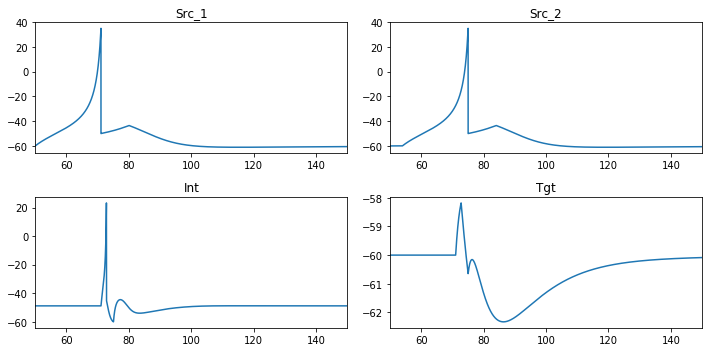

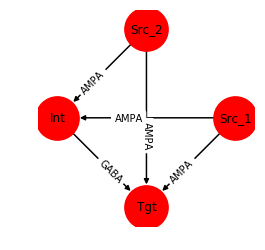

{'auc_epsp': 3.3089163082450948,
 'dt_epsp': 3.3200000000000074,
 'peak_epsp': 1.8200573036183769}

In [8]:
# Test running 1 simulation 

# global and constant variables 
globalVars = {'dt': 0.01*ms, 'tstop': 200*ms}
constVars = {'E_AMPA' : 0*mV, 'E_GABA' : -80*mV, 
             'tau_AMPA' : 2*ms, 'tau_GABA' : 10*ms}

# default values for synaptic conductance 
synapseVars = {'g_elec' : 0*nS, 'g_AMPA': 3*nS, 'g_GABA' : 8*nS} 
# this is to change default values of specific connections 
changeSynCond = {('Src_1','AMPA','Int') : 10*nS,
                 ('Src_2','AMPA','Int') : 10*nS } 

# DC input 
# note, although this is run for tstop = 200ms, the data that matter can only be expected within 100ms
# plus, need to start ti_inp a bit later than just 10ms to let Int settle due to I_hold application 
ti_inp = 50*ms; td_inp = 30*ms; tdiff_inp = 4*ms; 
dcstimVars = {'Src_1': {'i0': 200*pA, 'ti': ti_inp, 'tf': ti_inp+td_inp},
              'Src_2': {'i0': 200*pA, 'ti': ti_inp+tdiff_inp, 'tf': ti_inp+tdiff_inp+td_inp},
              'Int': {'i0': 60*pA, 'ti': 0*ms, 'tf': globalVars['tstop']},  
             }


nsO = netSimObj('../prm_files/prm.yaml', '../prm_files/net_conn.yaml', 'Net_1')
nsO.setGlobalVars(globalVars,constVars)
nsO.setSynapseVars(synapseVars,changeSynCond)
nsO.setDCStimVars(dcstimVars)
nsO.runSim(True)

%matplotlib inline
figure(figsize = (10, 5))
rcParams["font.size"] = 10
nsO.plotSimulatedData([],lim_x=(50,150))
figure(figsize = (3,3))
rcParams["font.size"] = 10
nsO.drawNetwork()

vm = nsO.returnData('Tgt')
tv  = nsO.data['t']
calc_IW(tv,vm)

In [ ]:
# Simulations with variations of dt_inp and I_hold 

# global and constant variables 
globalVars = {'dt': 0.01*ms, 'tstop': 200*ms}
constVars = {'E_AMPA' : 0*mV, 'E_GABA' : -80*mV, 
             'tau_AMPA' : 2*ms, 'tau_GABA' : 10*ms}

# default values for synaptic conductance 
synapseVars = {'g_elec' : 0*nS, 'g_AMPA': 3*nS, 'g_GABA' : 8*nS} 

# this is to change default values of specific connections 
changeSynCond = {('Src_1','AMPA','Int') : 10*nS,
                 ('Src_2','AMPA','Int') : 10*nS } 

dt_inp_vec = np.concatenate((np.arange(0,10,0.1),np.arange(10,20,1)))
ihold_int_vec = np.array([0,25,50,60])
num_dat = len(dt_inp_vec)*len(ihold_int_vec)
data2save = {'vars' : {'dt_inp':dt_inp_vec,
                       'ihold_int':ihold_int_vec}, 
             'cell_names' : tuple(nsO.cell_names), 
             'cell_types' : tuple(nsO.cell_types),
             'num_dat' : num_dat,
            }

# progress bar 
fprogress = FloatProgress(min=0, max=num_dat) # instantiate the bar
display(fprogress) # display the bar

startT = time.time() 
cnt_dat = 0

for ihold_int_var in ihold_int_vec: 
    for dt_inp_var in dt_inp_vec: 
        ti_inp = 50*ms; td_inp = 30*ms; tdiff_inp = dt_inp_var*ms; 
        dcstimVars = {'Src_1': {'i0': 200*pA, 'ti': ti_inp, 'tf': ti_inp+td_inp},
                      'Src_2': {'i0': 200*pA, 'ti': ti_inp+tdiff_inp, 'tf': ti_inp+tdiff_inp+td_inp},
                      'Int': {'i0': ihold_int_var*pA, 'ti': 0*ms, 'tf': globalVars['tstop']},  
                     }
        nsO = netSimObj('prm_files/prm.yaml', 'prm_files/net_conn.yaml', 'Net_1')
        nsO.setGlobalVars(globalVars,constVars)
        nsO.setSynapseVars(synapseVars,changeSynCond)
        nsO.setDCStimVars(dcstimVars)
        nsO.runSim(False)
        vm = nsO.returnData('Tgt')
        tv  = nsO.data['t']
        IW_data[(dt_inp_var,ihold_int_var)] = calc_IW(tv,vm)

        tmp_dict = {'var' : (dt_inp_var,ihold_int_var), 
                    'dat' : {'t': nsO.data['t']}, 
                    'iw'  : calc_IW(tv,vm)}
        for i in xrange(nsO.N): 
            tmp_dict['dat'][nsO.cell_names[i]] = nsO.returnData(nsO.cell_names[i])
        
        cnt_dat += 1 
        name_field = 'dat_%06d' %(cnt_dat)
        data2save[name_field] = tmp_dict
        
        fprogress.value += 1
        fprogress.description = '%.0f %s' %(100*(cnt_dat/num_dat),'%')

endT = time.time() 
print('Total time elapsed = %.3f min' %((endT-startT)/60)) 
scio.savemat('Net1_dtInpvsholdInt.mat', {'data2save' : data2save})

### Model 2a: 2 Src's, 2 Int's, 1 Tgt 
#### Electrically coupled interneurons
#### Variations of $\Delta t_{inp}$ and $G_{elec}$

In the "net_conn.yaml" file, this is "Net_2"

Total time elapsed = 1.079 s


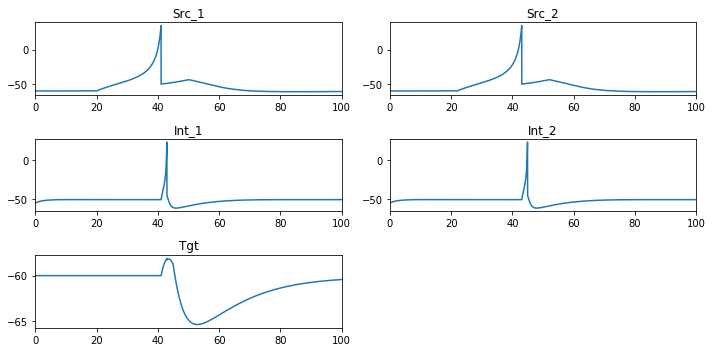

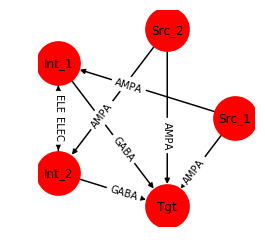

{'auc_epsp': 5.9122011284755294,
 'dt_epsp': 4.4700000000000024,
 'peak_epsp': 1.8812278937173801}

In [10]:
# Test running 1 simulation 

# global and constant variables 
globalVars = {'dt': 0.01*ms, 'tstop': 100*ms}
constVars = {'E_AMPA' : 0*mV, 'E_GABA' : -80*mV, 
             'tau_AMPA' : 2*ms, 'tau_GABA' : 10*ms}

# default values for synaptic conductance 
synapseVars = {'g_elec' : 0*nS, 'g_AMPA': 3*nS, 'g_GABA' : 8*nS} 
# this is to change default values of specific connections 
changeSynCond = {('Src_1','AMPA','Int_1') : 10*nS,
                 ('Src_2','AMPA','Int_2') : 10*nS } 

ti_inp = 20*ms; td_inp = 30*ms; tdiff_inp = 2*ms; 
dcstimVars = {'Src_1': {'i0': 200*pA, 'ti': ti_inp, 'tf': ti_inp+td_inp},
              'Src_2': {'i0': 200*pA, 'ti': ti_inp+tdiff_inp, 'tf': ti_inp+tdiff_inp+td_inp},
              'Int_1': {'i0': 50*pA, 'ti': 0*ms, 'tf': globalVars['tstop']},  
              'Int_2': {'i0': 50*pA, 'ti': 0*ms, 'tf': globalVars['tstop']},  
             }

nsO = netSimObj('../prm_files/prm.yaml', '../prm_files/net_conn.yaml', 'Net_2')
nsO.setGlobalVars(globalVars,constVars)
nsO.setSynapseVars(synapseVars,changeSynCond)
nsO.setDCStimVars(dcstimVars)
nsO.runSim(True)

%matplotlib inline
figure(figsize = (10, 5))
rcParams["font.size"] = 10
nsO.plotSimulatedData([],lim_x=(0,100))
figure(figsize = (3,3))
rcParams["font.size"] = 10
nsO.drawNetwork()

vm = nsO.returnData('Tgt')
tv  = nsO.data['t']
calc_IW(tv,vm)

In [ ]:
# Simulations with variations in dt_inp and G_elec

# global and constant variables 
globalVars = {'dt': 0.01*ms, 'tstop': 100*ms}
constVars = {'E_AMPA' : 0*mV, 'E_GABA' : -80*mV, 
             'tau_AMPA' : 2*ms, 'tau_GABA' : 10*ms}

# default values for synaptic conductance 
synapseVars = {'g_elec' : 0*nS, 'g_AMPA': 3*nS, 'g_GABA' : 8*nS} 

# this is to change default values of specific connections 
changeSynCond = {('Src_1','AMPA','Int_1') : 10*nS,
                 ('Src_2','AMPA','Int_2') : 10*nS } 

# 'tdiff_inp' here was just a place holder 
ti_inp = 50*ms; td_inp = 30*ms; tdiff_inp = 0*ms; 
dcstimVars = {'Src_1': {'i0': 200*pA, 'ti': ti_inp, 'tf': ti_inp+td_inp},
              'Src_2': {'i0': 200*pA, 'ti': ti_inp+tdiff_inp, 'tf': ti_inp+tdiff_inp+td_inp},
              'Int_1': {'i0': 50*pA, 'ti': 0*ms, 'tf': globalVars['tstop']},  
              'Int_2': {'i0': 50*pA, 'ti': 0*ms, 'tf': globalVars['tstop']},  
             }

g_elec_vec = np.arange(0,8,0.1)
dt_inp_vec = np.arange(0,5,0.1)

num_dat = len(dt_inp_vec)*len(g_elec_vec)
nsO = netSimObj('../prm_files/prm.yaml', '../prm_files/net_conn.yaml', 'Net_2')

data2save = {'vars' : {'g_elec': {'order': 1, 'range': g_elec_vec, 'unit': 'nS'}, 
                       'dt_inp': {'order': 2, 'range': dt_inp_vec, 'unit': 'ms'}},
             'cell_names' : tuple(nsO.cell_names), 
             'cell_types' : tuple(nsO.cell_types),
             'num_dat' : num_dat,
            }
cnt_save = 0 
save_every = 500
fprogress = FloatProgress(min=0, max=num_dat) # instantiate the bar
display(fprogress) # display the bar

IW_data = dict()
startT = time.time() 
cnt_dat = 0
%matplotlib inline

len_dtinpvec = len(dt_inp_vec)
min_elapsed = 2 

for dt_inp_var in dt_inp_vec:
    
    for g_elec_var in g_elec_vec: 
        
        synapseVars['g_elec'] = g_elec_var*nS 
        tdiff_inp = dt_inp_var*ms 
        dcstimVars['Src_2']['ti'] = ti_inp + tdiff_inp
        dcstimVars['Src_2']['tf'] = ti_inp + tdiff_inp + td_inp
        
        nsO = netSimObj('prm_files/prm.yaml', 'prm_files/net_conn.yaml', 'Net_2')
        nsO.setGlobalVars(globalVars,constVars)
        nsO.setSynapseVars(synapseVars,changeSynCond)
        nsO.setDCStimVars(dcstimVars)
        nsO.runSim(False)
        vm = nsO.returnData('Tgt')
        tv  = nsO.data['t']
        
        var_tuple = (g_elec_var, dt_inp_var)
        IW_data[var_tuple] = calc_IW(tv,vm)

        tmp_dict = {'var' : var_tuple, 
                    'dat' : {'t': nsO.data['t']}, 
                    'iw'  : calc_IW(tv,vm)}
        for i in xrange(nsO.N): 
            tmp_dict['dat'][nsO.cell_names[i]] = nsO.returnData(nsO.cell_names[i])
            
        cnt_dat += 1 
        name_field = 'dat_%06d' %(cnt_dat)
        data2save[name_field] = tmp_dict
        
        fprogress.value += 1
        percent_complete = 100*(cnt_dat/num_dat)
        fprogress.description = '%.0f %s' %(percent_complete,'%')
        
        currT = time.time() 
        curr_elapsed = (currT - startT)/60
        if curr_elapsed >= min_elapsed and (np.round(curr_elapsed) % min_elapsed) == 0: 
            estTleft = 100*curr_elapsed/percent_complete - curr_elapsed
            print('%.2f min - %.0f %s progress, est. %.2f min left' %(curr_elapsed,percent_complete,'%',estTleft))
            min_elapsed += 5
            
        if (cnt_dat > 0 and (cnt_dat % save_every) == 0) or cnt_dat == num_dat: 
            cnt_save += 1
            name_saved_file = 'Net2_GJvsdtInp_%03d.mat' %(cnt_save)
            scio.savemat(name_saved_file, {'data2save' : data2save})
            del data2save
            data2save = {'vars' : {'g_elec': {'order': 1, 'range': g_elec_vec, 'unit': 'nS'}, 
                                   'dt_inp': {'order': 2, 'range': dt_inp_vec, 'unit': 'ms'}},
                         'cell_names' : tuple(nsO.cell_names), 
                         'cell_types' : tuple(nsO.cell_types),
                         'num_dat' : num_dat,
                        }

endT = time.time() 
print('Total time elapsed = %.3f min' %((endT-startT)/60)) 

### Model 2a$^{norm}$: same network as Model 2a, with normalized synapses
$G_{AMPA \rightarrow Int}$ doubled and $G_{GABA \rightarrow Tgt}$ halved 

This is to compare Model 1b with Model 2a when Ints are strongly coupled

In [ ]:
# Simulations with normz GABA to Tgt and AMPA to Int 
prefs.codegen.target = 'cython'

# global and constant variables 
globalVars = {'dt': 0.01*ms, 'tstop': 100*ms}
constVars = {'E_AMPA' : 0*mV, 'E_GABA' : -80*mV, 
             'tau_AMPA' : 2*ms, 'tau_GABA' : 10*ms}

# default values for synaptic conductance 
synapseVars = {'g_elec' : 0*nS, 'g_AMPA': 3*nS, 'g_GABA' : 8*nS/2} # half G_GABA->Tgt

# this is to change default values of specific connections 
# double G_AMPA->Int
changeSynCond = {('Src_1','AMPA','Int_1') : 10*nS*2,
                 ('Src_2','AMPA','Int_2') : 10*nS*2 } 

ti_inp = 50*ms; td_inp = 30*ms; tdiff_inp = 0*ms; 
dcstimVars = {'Src_1': {'i0': 200*pA, 'ti': ti_inp, 'tf': ti_inp+td_inp},
              'Src_2': {'i0': 200*pA, 'ti': ti_inp+tdiff_inp, 'tf': ti_inp+tdiff_inp+td_inp},
              'Int_1': {'i0': 50*pA, 'ti': 0*ms, 'tf': globalVars['tstop']},  
              'Int_2': {'i0': 50*pA, 'ti': 0*ms, 'tf': globalVars['tstop']},  
             }

# expand parameter variations to see whole effects 
g_elec_vec = np.arange(0,15,0.2)
dt_inp_vec = np.concatenate((np.arange(0,10,0.125), np.arange(10, 20, 0.5)))

num_dat = len(dt_inp_vec)*len(g_elec_vec)
nsO = netSimObj('../prm_files/prm.yaml', '../prm_files/net_conn.yaml', 'Net_2')

data2save = {'vars' : {'g_elec': {'order': 1, 'range': g_elec_vec, 'unit': 'nS'}, 
                       'dt_inp': {'order': 2, 'range': dt_inp_vec, 'unit': 'ms'}},
             'cell_names' : tuple(nsO.cell_names), 
             'cell_types' : tuple(nsO.cell_types),
             'num_dat' : num_dat,
            }
cnt_save = 0 
save_every = 500
fprogress = FloatProgress(min=0, max=num_dat) # instantiate the bar
display(fprogress) # display the bar

IW_data = dict()
startT = time.time() 
cnt_dat = 0


len_dtinpvec = len(dt_inp_vec)
min_elapsed = 2 

for dt_inp_var in dt_inp_vec:
    
    for g_elec_var in g_elec_vec: 
        
        synapseVars['g_elec'] = g_elec_var*nS 
        tdiff_inp = dt_inp_var*ms 
        dcstimVars['Src_2']['ti'] = ti_inp + tdiff_inp
        dcstimVars['Src_2']['tf'] = ti_inp + tdiff_inp + td_inp
        
        nsO = netSimObj('../prm_files/prm.yaml', '../prm_files/net_conn.yaml', 'Net_2')
        nsO.setGlobalVars(globalVars,constVars)
        nsO.setSynapseVars(synapseVars,changeSynCond)
        nsO.setDCStimVars(dcstimVars)
        nsO.runSim(False)
        vm = nsO.returnData('Tgt')
        tv  = nsO.data['t']
        
        var_tuple = (g_elec_var, dt_inp_var)
        IW_data[var_tuple] = calc_IW(tv,vm)

        tmp_dict = {'var' : var_tuple, 
                    'dat' : {'t': nsO.data['t']}, 
                    'iw'  : calc_IW(tv,vm)}
        for i in xrange(nsO.N): 
            tmp_dict['dat'][nsO.cell_names[i]] = nsO.returnData(nsO.cell_names[i])
            
        cnt_dat += 1 
        name_field = 'dat_%06d' %(cnt_dat)
        data2save[name_field] = tmp_dict
        
        fprogress.value += 1
        percent_complete = 100*(cnt_dat/num_dat)
        fprogress.description = '%.0f %s' %(percent_complete,'%')
        
        currT = time.time() 
        curr_elapsed = (currT - startT)/60
        if curr_elapsed >= min_elapsed and (np.round(curr_elapsed) % min_elapsed) == 0: 
            estTleft = 100*curr_elapsed/percent_complete - curr_elapsed
            print('%.2f min - %.0f %s progress, est. %.2f min left' %(curr_elapsed,percent_complete,'%',estTleft))
            min_elapsed += 5
            
        if (cnt_dat > 0 and (cnt_dat % save_every) == 0) or cnt_dat == num_dat: 
            cnt_save += 1
            name_saved_file = 'Net2_GJvsdtInp_NormzGABA2TgtandNormzAMPA2Ints_%03d.mat' %(cnt_save)
            scio.savemat(name_saved_file, {'data2save' : data2save})
            del data2save
            data2save = {'vars' : {'g_elec': {'order': 1, 'range': g_elec_vec, 'unit': 'nS'}, 
                                   'dt_inp': {'order': 2, 'range': dt_inp_vec, 'unit': 'ms'}},
                         'cell_names' : tuple(nsO.cell_names), 
                         'cell_types' : tuple(nsO.cell_types),
                         'num_dat' : num_dat,
                        }

endT = time.time() 
print('Total time elapsed = %.3f min' %((endT-startT)/60)) 

### Model 2b: 2 Src's, 2 Int's, 1 Tgt
#### Electrically coupled and reciprocally inhibiting interneurons
#### Exploring the interaction between $\Delta t_{inp}$, $G_{elec}$ & $G_{GABA \rightarrow Int}$

In the "net_conn.yaml" file, this is "Net_3"

Total time elapsed = 1.062 s


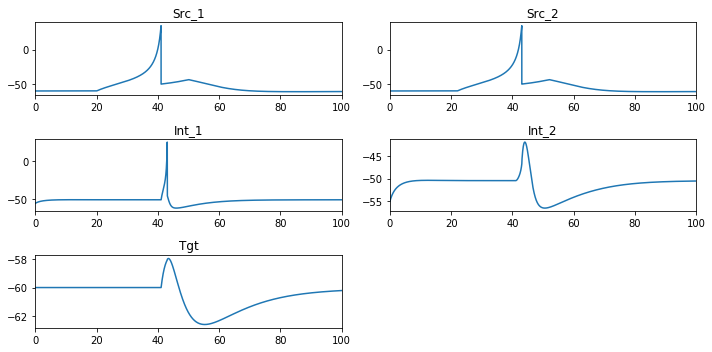

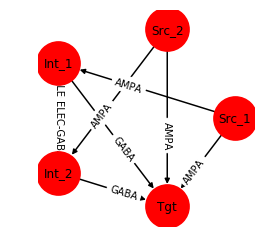

{'auc_epsp': 7.279348569688934,
 'dt_epsp': 5.8099999999999987,
 'peak_epsp': 2.0380198451700764}

In [12]:
# Test running 1 simulation 

# global and constant variables 
globalVars = {'dt': 0.01*ms, 'tstop': 100*ms}
constVars = {'E_AMPA' : 0*mV, 'E_GABA' : -80*mV, 
             'tau_AMPA' : 2*ms, 'tau_GABA' : 10*ms}

# default values for synaptic conductance 
synapseVars = {'g_elec' : 1*nS, 'g_AMPA': 3*nS, 'g_GABA' : 8*nS} 
# this is to change default values of specific connections 
changeSynCond = {('Src_1','AMPA','Int_1') : 10*nS,
                 ('Src_2','AMPA','Int_2') : 10*nS, 
                 ('Int_1','GABA','Int_2') : 7*nS,                 
                 ('Int_2','GABA','Int_1') : 7*nS,
                } 

ti_inp = 20*ms; td_inp = 30*ms; tdiff_inp = 2*ms; 
dcstimVars = {'Src_1': {'i0': 200*pA, 'ti': ti_inp, 'tf': ti_inp+td_inp},
              'Src_2': {'i0': 200*pA, 'ti': ti_inp+tdiff_inp, 'tf': ti_inp+tdiff_inp+td_inp},
              'Int_1': {'i0': 50*pA, 'ti': 0*ms, 'tf': globalVars['tstop']},  
              'Int_2': {'i0': 50*pA, 'ti': 0*ms, 'tf': globalVars['tstop']},  
             }

PRM_FILE = '../prm_files/prm.yaml'
NET_FILE = '../prm_files/net_conn.yaml'
NET_NAME = 'Net_3'
nsO = netSimObj(PRM_FILE, NET_FILE, NET_NAME)

nsO.setGlobalVars(globalVars,constVars)
nsO.setSynapseVars(synapseVars,changeSynCond)
nsO.setDCStimVars(dcstimVars)
nsO.runSim(True)

# %matplotlib notebook
%matplotlib inline
figure(figsize = (10, 5))
rcParams["font.size"] = 10
nsO.plotSimulatedData([],lim_x=(0,100))
figure(figsize = (3,3))
rcParams["font.size"] = 10
nsO.drawNetwork()

vm = nsO.returnData('Tgt')
tv  = nsO.data['t']
calc_IW(tv,vm)

In [ ]:
# Simulations with variations of dt_inp, G_elec and G_GABA between Int

# global and constant variables 
globalVars = {'dt': 0.01*ms, 'tstop': 100*ms}
constVars = {'E_AMPA' : 0*mV, 'E_GABA' : -80*mV, 
             'tau_AMPA' : 2*ms, 'tau_GABA' : 10*ms}

# default values for synaptic conductance 
synapseVars = {'g_elec' : 0*nS, 'g_AMPA': 3*nS, 'g_GABA' : 8*nS} 

# this is to change default values of specific connections 
changeSynCond = {('Src_1','AMPA','Int_1') : 10*nS,
                 ('Src_2','AMPA','Int_2') : 10*nS, 
                 ('Int_1','GABA','Int_2') : 0*nS,                 
                 ('Int_2','GABA','Int_1') : 0*nS }

ti_inp = 20*ms; td_inp = 30*ms; tdiff_inp = 0*ms; 
dcstimVars = {'Src_1': {'i0': 200*pA, 'ti': ti_inp, 'tf': ti_inp+td_inp},
              'Src_2': {'i0': 200*pA, 'ti': ti_inp+tdiff_inp, 'tf': ti_inp+tdiff_inp+td_inp},
              'Int_1': {'i0': 50*pA, 'ti': 0*ms, 'tf': globalVars['tstop']},  
              'Int_2': {'i0': 50*pA, 'ti': 0*ms, 'tf': globalVars['tstop']},  
             }

PRM_FILE = 'prm_files/prm.yaml'
NET_FILE = 'prm_files/net_conn.yaml'
NET_NAME = 'Net_3'

nsO = netSimObj(PRM_FILE, NET_FILE, NET_NAME)

g_elec_vec = np.arange(0,6,0.5)
g_gaba_int_vec = np.arange(0,8,0.5)
dt_inp_vec = np.arange(0,5,0.2)

num_dat = len(dt_inp_vec)*len(g_elec_vec)*len(g_gaba_int_vec)


data2save = {'vars' : {'g_elec': {'order': 1, 'range': g_elec_vec, 'unit': 'nS'}, 
                       'g_gaba_int': {'order': 2, 'range': g_gaba_int_vec, 'unit': 'nS'}, 
                       'dt_inp': {'order': 3, 'range': dt_inp_vec, 'unit': 'ms'}},
             'cell_names' : tuple(nsO.cell_names), 
             'cell_types' : tuple(nsO.cell_types),
             'num_dat' : num_dat}
cnt_save = 0 
save_every = 500

fprogress = FloatProgress(min=0, max=num_dat) # instantiate the bar
display(fprogress) # display the bar

IW_data = dict()
startT = time.time() 
cnt_dat = 0
%matplotlib inline

min_elapsed = 5

for dt_inp_var in dt_inp_vec: 
    for g_gaba_int_var in g_gaba_int_vec:
        for g_elec_var in g_elec_vec: 

            synapseVars['g_elec'] = g_elec_var*nS 

            changeSynCond = {('Src_1','AMPA','Int_1') : 10*nS,
                             ('Src_2','AMPA','Int_2') : 10*nS, 
                             ('Int_1','GABA','Int_2') : g_gaba_int_var*nS,                 
                             ('Int_2','GABA','Int_1') : g_gaba_int_var*nS }

            tdiff_inp = dt_inp_var*ms 
            dcstimVars['Src_2']['ti'] = ti_inp + tdiff_inp
            dcstimVars['Src_2']['tf'] = ti_inp + tdiff_inp + td_inp

            nsO = netSimObj(PRM_FILE, NET_FILE, NET_NAME)
            nsO.setGlobalVars(globalVars,constVars)
            nsO.setSynapseVars(synapseVars,changeSynCond)
            nsO.setDCStimVars(dcstimVars)
            nsO.runSim(False)
            vm = nsO.returnData('Tgt')
            tv  = nsO.data['t']

            var_tuple = (g_elec_var, g_gaba_int_var, dt_inp_var)
            IW_data[var_tuple] = calc_IW(tv,vm)

            tmp_dict = {'var' : var_tuple, 
                        'dat' : {'t': nsO.data['t']}, 
                        'iw'  : calc_IW(tv,vm)}
            for i in xrange(nsO.N): 
                tmp_dict['dat'][nsO.cell_names[i]] = nsO.returnData(nsO.cell_names[i])

            cnt_dat += 1 
            name_field = 'dat_%06d' %(cnt_dat)
            data2save[name_field] = tmp_dict

            fprogress.value += 1
            percent_complete = 100*(cnt_dat/num_dat)
            fprogress.description = '%.0f %s' %(percent_complete,'%')

            currT = time.time() 
            curr_elapsed = (currT - startT)/60
            if curr_elapsed >= min_elapsed and (np.round(curr_elapsed) % min_elapsed) == 0: 
                estTleft = 100*curr_elapsed/percent_complete - curr_elapsed
                print('%.2f min - %.0f %s progress, est. %.2f min left' %(curr_elapsed,percent_complete,'%',estTleft))
                min_elapsed += 10
                
            if (cnt_dat > 0 and (cnt_dat % save_every) == 0) or cnt_dat == num_dat: 
                cnt_save += 1
                name_saved_file = 'Net3_GJvsGABAIntvsdtInp_%03d.mat' %(cnt_save)
                scio.savemat(name_saved_file, {'data2save' : data2save})
                del data2save
                data2save = {'vars' : {'g_elec': {'order': 1, 'range': g_elec_vec, 'unit': 'nS'}, 
                                       'g_gaba_int': {'order': 2, 'range': g_gaba_int_vec, 'unit': 'nS'}, 
                                       'dt_inp': {'order': 3, 'range': dt_inp_vec, 'unit': 'ms'}},
                             'cell_names' : tuple(nsO.cell_names), 
                             'cell_types' : tuple(nsO.cell_types),
                             'num_dat' : num_dat}

endT = time.time() 
print('Total time elapsed = %.3f min' %((endT-startT)/60)) 
